# Introduction

- notebook by Jenn Williamson

This notebook imports the csv file that was output from notebook 2.

**NOTE: Version 0.11.0 of seaborn is required to run certain plots in this file, so use the code in the third cell in case certain plots are not working (seaborn changed the name of some of their plot functions between the old and new versions)**

A dataframe that consists of only countries in the region of Africa is created.

The dataframe is cleaned for modeling including the following:
 * Rows with null values are removed (this is where no protest occurred, but we think the row was included for time series analyis).
 * The null values in **participants_category** column are imputed based on the **participants** column
 
 * Drop columns that are text - such as **sources**, and also drop the demand/response columns except for the demand column that has all possible combinations of demands (**protesterdemand**), and the columns that each cover whether a given demand occurred for that data frame (such as **accomodations**) 
 
 * Three columns are one-hot encoded since they are categories: **country**,**participants_category**, **protesterdemand**

This dataframe is then used for modeling.  Modeling includes the following:

 * 7 model types were run for each of three cases, as described further below:
   * Logistic Regression
   * K-Nearest Neighbors
   * Decision Tree (**NOTE: only included in out-of-the-box models**)
   * Bagging
   * RandomForest
   * AdaBoost
   * SVC

 * Binary classification with accomodations as the target
   * the 7 model types are run out-of-the-box
   * the 6 model types are run using grid-search models with PCA
   * the 6 model types are run using grid-search models without PCA
   
   * **Random Forest Classifier with PCA gives the best results** although these are barely above the baseline performance
      * baseline score is: 87.6%
      * cv-score is: 88.8
      * train accuracy is: 88.9%
      * test accuracy is: 89.1%
   
 * Binary classification with whether state violence occurred as the target
   * the 7 model types are run out-of-the-box
   * the 6 model types are run using grid-search models without PCA
   * the 6 model types are run using grid-search models with PCA

   * **AdaBoost with PCA gives the best results** although these are barely above the baseline performance  
      * baseline score is: 87.1%
      * cv-score is: 88.7%
      * train accuracy is: 88.9%
      * test accuracy is: 88.8%

In [4]:
# run to update seaborn so that the new seaborn will work

# pip install seaborn==0.11.0

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import classification as cl

pd.set_option('display.max_columns',None)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier 
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [6]:
df = pd.read_csv('../data/df_all.csv')

In [7]:
df.columns

Index(['Unnamed: 0', 'country', 'ccode', 'year', 'region', 'protest',
       'protestnumber', 'startday', 'startmonth', 'startyear', 'endday',
       'endmonth', 'endyear', 'protesterviolence', 'location',
       'participants_category', 'participants', 'protesteridentity',
       'protesterdemand1', 'protesterdemand2', 'protesterdemand3',
       'protesterdemand4', 'stateresponse1', 'stateresponse2',
       'stateresponse3', 'stateresponse4', 'stateresponse5', 'stateresponse6',
       'stateresponse7', 'sources', 'notes', 'years', 'months', 'days',
       'total_days', 'dem_protesterdemand1', 'dem_protesterdemand2',
       'dem_protesterdemand3', 'dem_protesterdemand4', 'resp_stateresponse1',
       'resp_stateresponse2', 'resp_stateresponse3', 'resp_stateresponse4',
       'resp_stateresponse5', 'resp_stateresponse6', 'resp_stateresponse7',
       'state_violence', 'protesterdemand', 'stateresponse',
       'protesterdemand_int', 'protesterdemand_str', 'stateresponse_int',
       'st

In [8]:
africa_df = df[df['region'] == 'Africa'].copy()

In [9]:
list_of_countries = list(africa_df['country'].unique())

list_of_demands = ['labor wage dispute',
                   'land farm issue',
                   'police brutality',
                   'political behavior, process',
                   'price increases, tax policy',
                   'removal of politician',
                   'social restrictions']

list_of_responses = ['accomodation',
                     'arrests',
                     'beatings',
                     'crowd dispersal',
                     'ignore',
                     'killings',
                     'shootings']

# Clean Dataframe for modeling

In [10]:
africa_df.head()

,Unnamed: 0,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,location,participants_category,participants,protesteridentity,protesterdemand1,protesterdemand2,protesterdemand3,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,years,months,days,total_days,dem_protesterdemand1,dem_protesterdemand2,dem_protesterdemand3,dem_protesterdemand4,resp_stateresponse1,resp_stateresponse2,resp_stateresponse3,resp_stateresponse4,resp_stateresponse5,resp_stateresponse6,resp_stateresponse7,state_violence,protesterdemand,stateresponse,protesterdemand_int,protesterdemand_str,stateresponse_int,stateresponse_str,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings
7974,7974,Cape Verde,402,1990,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0
7975,7975,Cape Verde,402,1991,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0
7976,7976,Cape Verde,402,1992,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0
7977,7977,Cape Verde,402,1993,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0
7978,7978,Cape Verde,402,1994,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0


In [11]:
africa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 7974 to 11603
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   3630 non-null   int64  
 1   country                      3630 non-null   object 
 2   ccode                        3630 non-null   int64  
 3   year                         3630 non-null   int64  
 4   region                       3630 non-null   object 
 5   protest                      3630 non-null   int64  
 6   protestnumber                3630 non-null   int64  
 7   startday                     3630 non-null   float64
 8   startmonth                   3630 non-null   float64
 9   startyear                    3630 non-null   float64
 10  endday                       3630 non-null   float64
 11  endmonth                     3630 non-null   float64
 12  endyear                      3630 non-null   float64
 13  protesterviole

## Address null values

In [12]:
# drops rows where no protest occurs (i.e. startday column is null)
africa_df_protests = africa_df[africa_df['startday'].notna()].copy()

In [13]:
africa_df_protests.isnull().sum()[africa_df_protests.isnull().sum() != 0]

location                 587
protesteridentity        587
sources                  589
notes                    587
dem_protesterdemand1    3630
dem_protesterdemand2    3630
dem_protesterdemand3    3630
dem_protesterdemand4    3630
resp_stateresponse1     3630
resp_stateresponse2     3630
resp_stateresponse3     3630
resp_stateresponse4     3630
resp_stateresponse5     3630
resp_stateresponse6     3630
resp_stateresponse7     3630
dtype: int64

## Analyze remaining columns with nulls

In [223]:
part_cats = africa_df_protests[['participants_category','participants','sources']].copy()

part_cats[part_cats['participants_category'].isnull()]

,participants_category,participants,sources
8320,NaN,100s,Hundreds attend anti coup rally in Mauritania ...
8670,NaN,50+,Guinea opposition protest turns violent Agence...
8826,NaN,50+,"AG Besieged New Democrat Monrovia , November ..."
9167,NaN,10000+,Nigerian Police Open Fire in Religious Clash T...
9387,NaN,>50,Central Africa cabinet meets to debate econom...
9395,NaN,3000,"1 1,000 call for peace in CAR march. Agence..."
9397,NaN,60,Witnesses: Central African Republic police sh...
9406,NaN,>50,14 die after Muslims block march. The Star ...
9539,NaN,1000s,"Strike grips Kinshasa. Morning Star, January..."
9698,NaN,100,GUILTY: WESTERN FIRMS ACCUSED OVER AIDS AT NA...


In [224]:
part_cats[part_cats['participants'].isnull()]

,participants_category,participants,sources
8709,100-999,NaN,Police use tear gas to disperse university pro...
11295,1000-1999,NaN,Women and Gender; Women Protest Brutal Rape Af...
11517,1000-1999,NaN,"Opposition leader, French citizens detained in..."


In [225]:
part_cats[part_cats['sources'].isnull()]

,participants_category,participants,sources
10075,100-999,hundreds,NaN
10515,100-999,500,NaN


### Based on above:

* The **participants_category** is more helpful, so where missing values occur - these could be imputed based on the **participants**

* The **participants** column can be dropped for modeling

* The **sources** column is more for reference and can be dropped for modelling

In [226]:
part_cats[part_cats['participants_category'].isnull()]

,participants_category,participants,sources
8320,NaN,100s,Hundreds attend anti coup rally in Mauritania ...
8670,NaN,50+,Guinea opposition protest turns violent Agence...
8826,NaN,50+,"AG Besieged New Democrat Monrovia , November ..."
9167,NaN,10000+,Nigerian Police Open Fire in Religious Clash T...
9387,NaN,>50,Central Africa cabinet meets to debate econom...
9395,NaN,3000,"1 1,000 call for peace in CAR march. Agence..."
9397,NaN,60,Witnesses: Central African Republic police sh...
9406,NaN,>50,14 die after Muslims block march. The Star ...
9539,NaN,1000s,"Strike grips Kinshasa. Morning Star, January..."
9698,NaN,100,GUILTY: WESTERN FIRMS ACCUSED OVER AIDS AT NA...


In [227]:
# input options

list(part_cats['participants_category'].unique())

['100-999', '2000-4999', '5000-10000', '50-99', '>10000', '1000-1999', nan]

In [228]:
africa_df_protests_clean = africa_df_protests.copy()

In [229]:
nums_to_50 = [8670, 8826, 9387, 9397, 9406, 9700, 9701]
nums_to_100 = [8320, 9698, 9704, 9742]
nums_to_1000 = [9539]  # CONSIDER REVIEWING THIS - COULD BE MORE
nums_to_2000 = [9395]
nums_to_10000 = [9167]

#Update values

for location in nums_to_50:
    africa_df_protests_clean['participants_category'].loc[location] = '50-99' 

for location in nums_to_100:
    africa_df_protests_clean['participants_category'].loc[location] = '100-999' 
    
for location in nums_to_1000:
    africa_df_protests_clean['participants_category'].loc[location] = '1000-1999' 
    
for location in nums_to_2000:
    africa_df_protests_clean['participants_category'].loc[location] = '2000-4999' 
    
for location in nums_to_10000:
    africa_df_protests_clean['participants_category'].loc[location] = '>10000' 

/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [230]:
# verify which columns that remain have nulls 
africa_df_protests_clean.isnull().sum()[africa_df_protests_clean.isnull().sum() != 0]

participants    3
sources         2
dtype: int64

### as noted above - will be dropping columns participants and sources

## Determine which columns to keep

In [231]:
africa_df_protests_clean.head(3)

,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,location,participants_category,participants,protesteridentity,protesterdemand1,protesterdemand2,protesterdemand3,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,years,months,days,total_days,protesterdemand,stateresponse,protesterdemand_int,protesterdemand_str,stateresponse_int,stateresponse_str,state_violence,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,.,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,..1
7989,Cape Verde,402,2005,Africa,1,1,16.0,3.0,2005.0,16.0,3.0,2005.0,1.0,Praia,100-999,500,immigrants,1.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,"Police, immigrants clash in Cape Verde Xinhua ...",Immigrants protesting violence committed again...,0.0,0.0,0.0,0.0,1.0,1000.0,1,1,1000,1000,0.0,0,0,0,1,0,0,0.0,0.0,0,0,0,1.0,0.0,0,0.0,0.0
7990,Cape Verde,402,2005,Africa,1,2,19.0,3.0,2005.0,19.0,3.0,2005.0,0.0,Praia,100-999,500,Movement for Democracy MPD,1.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,Demonstrators in Cape Verde march against crim...,Protests organized by main opposition party ag...,0.0,0.0,0.0,0.0,1.0,10.0,1,1,10,10,0.0,0,0,0,1,0,0,0.0,0.0,0,0,0,0.0,1.0,0,0.0,0.0
8009,Guinea-Bissau,404,1994,Africa,1,1,4.0,1.0,1994.0,4.0,1.0,1994.0,0.0,Bissau,2000-4999,Thousands,Supporters of Rebuild and Develop Party PRD,1.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,1. Trial Begins For Opposition Leader Accused...,Thousands of demonstrators protested politica...,0.0,0.0,0.0,0.0,1.0,11.0,1,1,11,11,0.0,0,0,0,1,0,0,0.0,0.0,1,0,0,0.0,1.0,0,0.0,0.0


In [232]:
africa_df_protests_clean.columns

Index(['country', 'ccode', 'year', 'region', 'protest', 'protestnumber',
       'startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear',
       'protesterviolence', 'location', 'participants_category',
       'participants', 'protesteridentity', 'protesterdemand1',
       'protesterdemand2', 'protesterdemand3', 'protesterdemand4',
       'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4',
       'stateresponse5', 'stateresponse6', 'stateresponse7', 'sources',
       'notes', 'years', 'months', 'days', 'total_days', 'protesterdemand',
       'stateresponse', 'protesterdemand_int', 'protesterdemand_str',
       'stateresponse_int', 'stateresponse_str', 'state_violence',
       'labor wage dispute', 'land farm issue', 'police brutality',
       'political behavior, process', 'price increases, tax policy',
       'removal of politician', 'social restrictions', '.', 'accomodation',
       'arrests', 'beatings', 'crowd dispersal', 'ignore', 'killings',
    

In [243]:
columns_to_drop = ['ccode','region','location','participants','protesteridentity', 
                   'protesterdemand1','protesterdemand2', 'protesterdemand3', 'protesterdemand4',
                   'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4',
                   'stateresponse5', 'stateresponse6', 'stateresponse7', 
                   'sources','notes', 
                   'protesterdemand_int', 'protesterdemand_str',
                   'stateresponse_int', 'stateresponse_str', 
                   '.','..1'
                   ]

africa_df_protests_clean_cols = africa_df_protests_clean.drop(columns = columns_to_drop).copy()
africa_df_protests_clean_cols.head()

,country,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,participants_category,years,months,days,total_days,protesterdemand,stateresponse,state_violence,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings
7989,Cape Verde,2005,1,1,16.0,3.0,2005.0,16.0,3.0,2005.0,1.0,100-999,0.0,0.0,0.0,0.0,1.0,1000.0,0.0,0,0,0,1,0,0,0.0,0,0,0,1.0,0.0,0,0.0
7990,Cape Verde,2005,1,2,19.0,3.0,2005.0,19.0,3.0,2005.0,0.0,100-999,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0.0,1.0,0,0.0
8009,Guinea-Bissau,1994,1,1,4.0,1.0,1994.0,4.0,1.0,1994.0,0.0,2000-4999,0.0,0.0,0.0,0.0,1.0,11.0,0.0,0,0,0,1,0,0,0.0,1,0,0,0.0,1.0,0,0.0
8014,Guinea-Bissau,1999,1,1,3.0,11.0,1999.0,3.0,11.0,1999.0,0.0,100-999,0.0,0.0,0.0,0.0,10.0,1.0,0.0,1,0,0,0,0,0,0.0,1,0,0,0.0,0.0,0,0.0
8015,Guinea-Bissau,1999,1,2,28.0,11.0,1999.0,28.0,11.0,1999.0,1.0,100-999,0.0,0.0,0.0,0.0,1.0,1000.0,0.0,0,0,0,1,0,0,0.0,0,0,0,1.0,0.0,0,0.0


## Determine which columns to one-hot encode

In [244]:
cats_to_encode = ['country','participants_category','protesterdemand']

In [245]:
all_encoded = pd.get_dummies(africa_df_protests_clean_cols, columns = cats_to_encode, drop_first = True)

## Do last checks before model

In [246]:
all_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3043 entries, 7989 to 11599
Columns: 121 entries, year to protesterdemand_1100011.0
dtypes: float64(17), int64(13), uint8(91)
memory usage: 1007.4 KB


In [247]:
all_encoded.describe()

,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,stateresponse,state_violence,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
count,3043.000000,3043.0,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3.043000e+03,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000
mean,2006.391061,1.0,8.841275,15.806441,6.141637,2006.391061,15.890569,6.147880,2006.392047,0.373973,0.000986,0.006244,0.084128,0.634407,1.109730e+05,0.128163,0.163654,0.042392,0.065067,0.680578,0.079527,0.131449,0.033848,0.1261

In [90]:
all_encoded.describe()

,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,stateresponse,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
count,3043.000000,3043.0,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3.043000e+03,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.0,3043.000000,3043.000000,3043.000000,3043.000000,3043.0,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000
mean,2006.391061,1.0,8.841275,15.806441,6.141637,2006.391061,15.890569,6.147880,2006.392047,0.373973,0.000986,0.006244,0.084128,0.634407,1.109730e+05,0.163654,0.042392,0.065067,0.680578,0.079527,0.131449,0.0,0.123891,0.165626,0.076898,0.433782,0.0,0.100887,0.127506

In [248]:
all_encoded.isnull().sum()[all_encoded.isnull().sum() != 0]

Series([], dtype: int64)

# Binary classification - target is accommodations

### note that one row has accommodation = 2 - this row appears once and unclear if data entered correctly. - so oing to drop (likely it should just be 1, but it won't make a difference)

In [146]:
all_encoded[all_encoded['accomodation'] == 2]

,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,stateresponse,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
11037,2010,1,3,12.0,7.0,2010.0,1.0,8.0,2010.0,1.0,0.0,1.0,-11.0,19.5,1012.0,1,0,0,1,0,0,0.0,2,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [151]:
africa_df_protests_clean.loc[11037];

In [153]:
all_encoded = all_encoded.drop(11037, axis = 0).copy()

### Create X, y dataframes

In [249]:
columns_to_drop = list_of_responses + ['stateresponse','state_violence']
columns_of_interests = 'accomodation'

X = all_encoded.drop(columns = columns_to_drop)
y = all_encoded[columns_of_interests]

X.head()

,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
7989,2005,1,1,16.0,3.0,2005.0,16.0,3.0,2005.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7990,2005,1,2,19.0,3.0,2005.0,19.0,3.0,2005.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8009,1994,1,1,4.0,1.0,1994.0,4.0,1.0,1994.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8014,1999,1,1,3.0,11.0,1999.0,3.0,11.0,1999.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8015,1999,1,2,28.0,11.0,1999.0,28.0,11.0,1999.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [156]:
y.head()

7989    0
7990    0
8009    1
8014    1
8015    0
Name: accomodation, dtype: int64

## Baseline Scores

In [198]:
y.value_counts()

0    2667
1     375
Name: accomodation, dtype: int64

In [179]:
round(y.value_counts(normalize=True),3)

0    0.877
1    0.123
Name: accomodation, dtype: float64

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

### double check baselines for y_train and y_test

In [197]:
round(y_train.value_counts(normalize = True), 3)

0    0.877
1    0.123
Name: accomodation, dtype: float64

In [196]:
round(y_test.value_counts(normalize = True), 3)

0    0.876
1    0.124
Name: accomodation, dtype: float64

In [192]:
y_test.value_counts()

0    667
1     94
Name: accomodation, dtype: int64

## Scale Data

In [165]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Run out-of-the-box models on the data

In [166]:
log = LogisticRegression()
knn_c = KNeighborsClassifier()
dec_c = DecisionTreeClassifier()
bag_c = BaggingClassifier()
ran_c = RandomForestClassifier()
ada_c = AdaBoostClassifier()
svc = SVC()

models_c = [log, knn_c, dec_c, bag_c, ran_c, ada_c, svc]

def eval_models(list_of_models, X_train_sc,y_train, X_test_sc, y_test):
    for model in models_c:
        model.fit(X_train_sc, y_train)

        # Review Accuracy
        train_acc_score = model.score(X_train_sc, y_train)
        test_acc_score = model.score(X_test_sc, y_test)    
        print(f'For model {model}:')
        print(f'     Train Acc score: {train_acc_score.round(4)}\n     Test Acc score: {test_acc_score.round(4)}')


        # Create prediction to get f1_score
        train_pred = model.predict(X_train_sc)
        test_pred = model.predict(X_test_sc)

        train_f1 =f1_score(y_train, train_pred, average='binary')
        test_f1 = f1_score(y_test, test_pred, average='binary')

        print(f'     Train f1 score: {train_f1.round(3)}\n     Test f1 score: {test_f1.round(3)}\n\n')

In [167]:
eval_models(models_c, X_train_sc,y_train, X_test_sc, y_test)

For model LogisticRegression():
     Train Acc score: 0.8882
     Test Acc score: 0.8857
     Train f1 score: 0.234
     Test f1 score: 0.256


For model KNeighborsClassifier():
     Train Acc score: 0.8987
     Test Acc score: 0.8817
     Train f1 score: 0.36
     Test f1 score: 0.262


For model DecisionTreeClassifier():
     Train Acc score: 1.0
     Test Acc score: 0.8463
     Train f1 score: 1.0
     Test f1 score: 0.346


For model BaggingClassifier():
     Train Acc score: 0.9847
     Test Acc score: 0.8765
     Train f1 score: 0.934
     Test f1 score: 0.277


For model RandomForestClassifier():
     Train Acc score: 1.0
     Test Acc score: 0.8909
     Train f1 score: 1.0
     Test f1 score: 0.291


For model AdaBoostClassifier():
     Train Acc score: 0.8882
     Test Acc score: 0.883
     Train f1 score: 0.265
     Test f1 score: 0.239


For model SVC():
     Train Acc score: 0.8948
     Test Acc score: 0.8896
     Train f1 score: 0.259
     Test f1 score: 0.236




In [168]:
# Function to review results

def results(fxn_name,X_test,y_test, X_train, y_train):

    #calculate cross-val score
    cvs = fxn_name.best_score_
    print('Best Score(cross_val_score) is: ', cvs)
    print('----------------------------------------------------------------------')
    
    # best params for the score
    bps = fxn_name.best_params_
    print('Best parameters for the best score(cross_val_score) are: ', bps)
    print('----------------------------------------------------------------------')
    
    # accuracy scores
    train_sc = fxn_name.score(X_train, y_train) 
    test_sc = fxn_name.score(X_test, y_test)
    print('Train score is: ', train_sc)
    print('Test score is: ', test_sc)
    print('----------------------------------------------------------------------')
    
    #Review predictions
    preds = fxn_name.predict(X_test)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    plot_confusion_matrix(fxn_name, X_test, y_test, cmap='Blues', values_format='d');

    # Calculate the specificity and sensitivity
    spec = tn / (tn + fp)
    print('Specificity: ', spec)
    
    sens = tp / (tp + fn)
    print('Sensitivity: ', sens)

## Try pipelines with PCA and grid search (note scaling was done above)

In [189]:
pipe_log = Pipeline([
    ('pc',PCA()),
    ('model',LogisticRegression())
])

log_params = {'pc__n_components':[10,15,20],
              'model__max_iter': [500, 1000],
              'model__C': [.1, 1, 10, 100],
              'model__solver': ['liblinear', 'lbfgs', 'sag'],
              'model__penalty': ['l2']}

log = GridSearchCV(pipe_log,
                     log_params,
                     cv=5,
                     verbose=1)

log.fit(X_train_sc,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   19.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'sag'],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8825079657568429
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.1, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'sag', 'pc__n_components': 20}
----------------------------------------------------------------------
Train score is:  0.8882069267864972
Test score is:  0.8909329829172142
----------------------------------------------------------------------
Specificity:  0.9985007496251874
Sensitivity:  0.1276595744680851


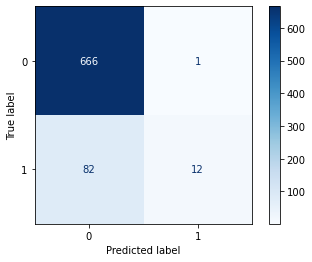

In [190]:
results(log,X_test_sc,y_test, X_train_sc, y_train)

In [169]:
pipe_knn = Pipeline([
    ('pc',PCA()),
    ('model',KNeighborsClassifier())
])

knn_params = {'pc__n_components':[10,15,20],
              'model__n_neighbors':[3,4,5,6],
             'model__p':[2,3,4]}

knn = GridSearchCV(pipe_knn,
                     knn_params,
                     cv=5,
                     verbose=1)

knn.fit(X_train_sc,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 4, 5, 6],
                         'model__p': [2, 3, 4],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8877672847326193
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__n_neighbors': 6, 'model__p': 3, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8899605436212188
Test score is:  0.8896189224704336
----------------------------------------------------------------------
Specificity:  0.9955022488755623
Sensitivity:  0.13829787234042554


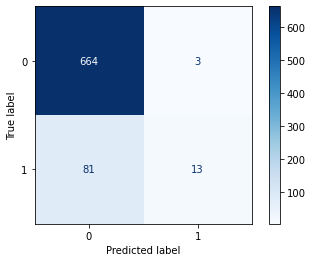

In [170]:
results(knn,X_test_sc,y_test, X_train_sc, y_train)

In [3]:
pipe_rfc = Pipeline([
    ('pc',PCA()),
    ('model',RandomForestClassifier())
])
rfc_params = {'pc__n_components':[10,15,20],
              'model__criterion':['gini','entropy'],
              'model__max_features':['auto','sqrt','log2'],
             'model__ccp_alpha':[0.01,0.05,0.07]}
# Support Vector Classifier was modelled in different Notebook due to significant runtimes.
rfc = GridSearchCV(pipe_rfc,
                     rfc_params,
                     cv=5,
                     verbose=1)
rfc.fit(X_train_sc,y_train)

NameError: name 'X_train_sc' is not defined

Best Score(cross_val_score) is:  0.8882078006833275
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__ccp_alpha': 0.01, 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'pc__n_components': 15}
----------------------------------------------------------------------
Train score is:  0.8886453309951775
Test score is:  0.8909329829172142
----------------------------------------------------------------------
Specificity:  0.9970014992503748
Sensitivity:  0.13829787234042554


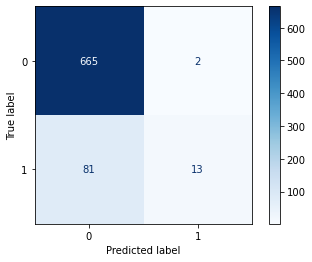

In [172]:
results(rfc,X_test_sc,y_test, X_train_sc, y_train)

### The RFC model performed the best here for accommodations, but only barely above the baseline

In [2]:
### BEST MODEL

cl.con_plot(rfc, X_test_sc,y_test, 'Random Forest Classifier')

NameError: name 'rfc' is not defined

In [173]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada.fit(X_train_sc,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'model__learning_rate': [0.5, 1, 1.5],
                         'model__n_estimators': [40, 50, 60],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8873325271603516
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__learning_rate': 0.5, 'model__n_estimators': 40, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.889083735203858
Test score is:  0.8883048620236531
----------------------------------------------------------------------
Specificity:  0.9970014992503748
Sensitivity:  0.11702127659574468


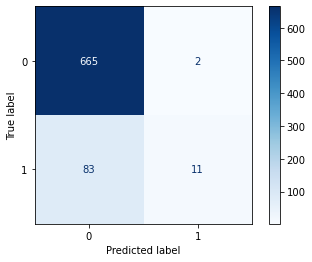

In [174]:
results(ada,X_test_sc,y_test, X_train_sc, y_train)

In [175]:
pipe_bag = Pipeline([
    ('pc',PCA()),
    ('model',BaggingClassifier())
])
bag_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[10,20,30],
              'model__max_samples':[1,2,3]
             }
bag = GridSearchCV(pipe_bag,
                     bag_params,
                     cv=5,
                     verbose=1)
bag.fit(X_train_sc,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   26.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', BaggingClassifier())]),
             param_grid={'model__max_samples': [1, 2, 3],
                         'model__n_estimators': [10, 20, 30],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8772476870513263
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__max_samples': 3, 'model__n_estimators': 10, 'pc__n_components': 15}
----------------------------------------------------------------------
Train score is:  0.8768084173608066
Test score is:  0.8764783180026281
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


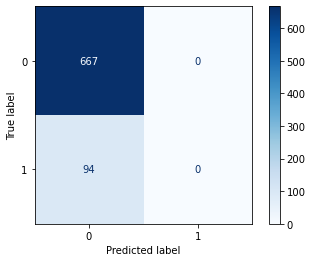

In [176]:
results(bag,X_test_sc,y_test, X_train_sc, y_train)

In [199]:
pipe_svc = Pipeline([
    ('pc',PCA()),
    ('model',SVC())
])
svc_params = {'pc__n_components':[10,15,20],
              'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc = GridSearchCV(pipe_svc,
                     svc_params,
                     cv=5,
                     verbose=1)
svc.fit(X_train_sc,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.7s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('pc', PCA()), ('model', SVC())]),
             param_grid={'model__C': [0.01, 0.05], 'model__degree': [3, 4, 5],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8768090905600981
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.01, 'model__degree': 3, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8768084173608066
Test score is:  0.8764783180026281
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


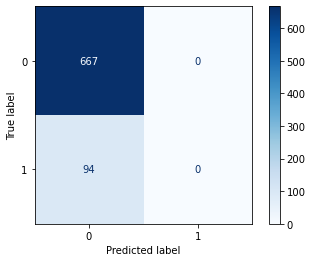

In [200]:
results(svc,X_test_sc,y_test, X_train_sc, y_train)

## Try pipelines without PCA and grid search (note scaling was done above)

In [203]:
pipe_log = Pipeline([
    ('model',LogisticRegression())
])

log_params = {'model__max_iter': [500, 1000],
              'model__C': [.1, 1, 10, 100],
              'model__solver': ['liblinear', 'lbfgs', 'sag'],
              'model__penalty': ['l2']}

log2 = GridSearchCV(pipe_log,
                     log_params,
                     cv=5,
                     verbose=1)

log2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'sag']},
             verbose=1)

Best Score(cross_val_score) is:  0.8816317325041269
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.1, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
----------------------------------------------------------------------
Train score is:  0.8886453309951775
Test score is:  0.885676741130092
----------------------------------------------------------------------
Specificity:  0.9895052473763118
Sensitivity:  0.14893617021276595


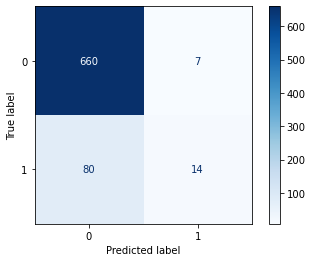

In [204]:
results(log2,X_test_sc,y_test, X_train_sc, y_train)

In [205]:
pipe_knn = Pipeline([
    ('model',KNeighborsClassifier())
])

knn_params = {'model__n_neighbors':[3,4,5,6],
             'model__p':[2,3,4]}

knn2 = GridSearchCV(pipe_knn,
                     knn_params,
                     cv=5,
                     verbose=1)

knn2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   48.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 4, 5, 6],
                         'model__p': [2, 3, 4]},
             verbose=1)

Best Score(cross_val_score) is:  0.8846999884832432
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__n_neighbors': 6, 'model__p': 4}
----------------------------------------------------------------------
Train score is:  0.893467777290662
Test score is:  0.8883048620236531
----------------------------------------------------------------------
Specificity:  0.9940029985007496
Sensitivity:  0.13829787234042554


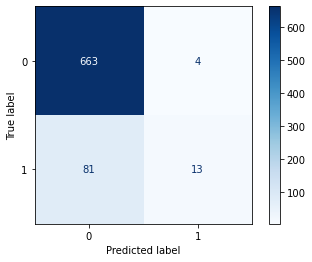

In [206]:
results(knn2,X_test_sc,y_test, X_train_sc, y_train)

In [207]:
pipe_rfc = Pipeline([
    ('model',RandomForestClassifier())
])
rfc_params = {'model__criterion':['gini','entropy'],
              'model__max_features':['auto','sqrt','log2'],
             'model__ccp_alpha':[0.01,0.05,0.07]}
# Support Vector Classifier was modelled in different Notebook due to significant runtimes.
rfc2 = GridSearchCV(pipe_rfc,
                     rfc_params,
                     cv=5,
                     verbose=1)
rfc2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   45.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', RandomForestClassifier())]),
             param_grid={'model__ccp_alpha': [0.01, 0.05, 0.07],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_features': ['auto', 'sqrt', 'log2']},
             verbose=1)

Best Score(cross_val_score) is:  0.8785634765250105
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__ccp_alpha': 0.01, 'model__criterion': 'entropy', 'model__max_features': 'auto'}
----------------------------------------------------------------------
Train score is:  0.8768084173608066
Test score is:  0.8764783180026281
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


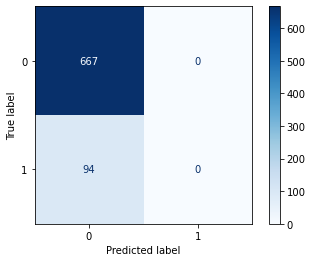

In [208]:
results(rfc2,X_test_sc,y_test, X_train_sc, y_train)

In [209]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada2 = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'model__learning_rate': [0.5, 1, 1.5],
                         'model__n_estimators': [40, 50, 60]},
             verbose=1)

Best Score(cross_val_score) is:  0.8847028676724635
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__learning_rate': 0.5, 'model__n_estimators': 40}
----------------------------------------------------------------------
Train score is:  0.8886453309951775
Test score is:  0.8869908015768725
----------------------------------------------------------------------
Specificity:  0.9940029985007496
Sensitivity:  0.1276595744680851


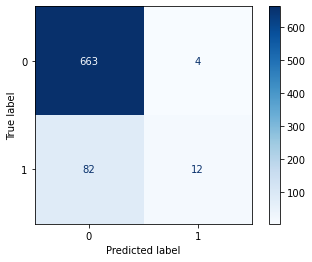

In [210]:
results(ada2,X_test_sc,y_test, X_train_sc, y_train)

In [211]:
pipe_bag = Pipeline([
    ('model',BaggingClassifier())
])
bag_params = {'model__n_estimators':[10,20,30],
              'model__max_samples':[1,2,3]
             }
bag2 = GridSearchCV(pipe_bag,
                     bag_params,
                     cv=5,
                     verbose=1)
bag2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    2.9s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', BaggingClassifier())]),
             param_grid={'model__max_samples': [1, 2, 3],
                         'model__n_estimators': [10, 20, 30]},
             verbose=1)

Best Score(cross_val_score) is:  0.8768090905600981
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__max_samples': 1, 'model__n_estimators': 10}
----------------------------------------------------------------------
Train score is:  0.8768084173608066
Test score is:  0.8764783180026281
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


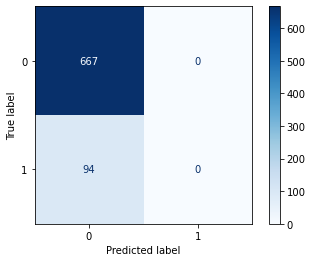

In [212]:
results(bag2,X_test_sc,y_test, X_train_sc, y_train)

In [213]:
pipe_bag = Pipeline([
    ('model',SVC())
])
svc_params = {'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc2 = GridSearchCV(pipe_bag,
                     svc_params,
                     cv=5,
                     verbose=1)
svc2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    9.2s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', SVC())]),
             param_grid={'model__C': [0.01, 0.05], 'model__degree': [3, 4, 5]},
             verbose=1)

# Binary Modeling - target is whether state violence occured

In [250]:
columns_to_drop = list_of_responses + ['stateresponse','state_violence']
columns_of_interests = 'state_violence'

X_v = all_encoded.drop(columns = columns_to_drop)
y_v = all_encoded[columns_of_interests]


X_v.head()

,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
7989,2005,1,1,16.0,3.0,2005.0,16.0,3.0,2005.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7990,2005,1,2,19.0,3.0,2005.0,19.0,3.0,2005.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8009,1994,1,1,4.0,1.0,1994.0,4.0,1.0,1994.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8014,1999,1,1,3.0,11.0,1999.0,3.0,11.0,1999.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8015,1999,1,2,28.0,11.0,1999.0,28.0,11.0,1999.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [251]:
y_v.head()

7989    0.0
7990    0.0
8009    0.0
8014    0.0
8015    0.0
Name: state_violence, dtype: float64

In [254]:
# Train Test Split
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_v, y_v, stratify = y_v, random_state = 42)

## Baseline Score

In [252]:
y_v.value_counts()

0.0    2653
1.0     390
Name: state_violence, dtype: int64

In [253]:
y_v.value_counts(normalize=True)

0.0    0.871837
1.0    0.128163
Name: state_violence, dtype: float64

In [255]:
y_train_v.value_counts(normalize=True)

0.0    0.872042
1.0    0.127958
Name: state_violence, dtype: float64

In [256]:
y_test_v.value_counts(normalize=True)

0.0    0.871222
1.0    0.128778
Name: state_violence, dtype: float64

## Scale data

In [257]:
ss = StandardScaler()

X_train_sc_v = ss.fit_transform(X_train_v)
X_test_sc_v = ss.transform(X_test_v)

## Out-of-the-box-models on the data

In [258]:
log = LogisticRegression()
knn_c = KNeighborsClassifier()
dec_c = DecisionTreeClassifier()
bag_c = BaggingClassifier()
ran_c = RandomForestClassifier()
ada_c = AdaBoostClassifier()
svc = SVC()

models_c = [log, knn_c, dec_c, bag_c, ran_c, ada_c, svc]

def eval_models(list_of_models, X_train_sc,y_train, X_test_sc, y_test):
    for model in models_c:
        model.fit(X_train_sc, y_train)

        # Review Accuracy
        train_acc_score = model.score(X_train_sc, y_train)
        test_acc_score = model.score(X_test_sc, y_test)    
        print(f'For model {model}:')
        print(f'     Train Acc score: {train_acc_score.round(4)}\n     Test Acc score: {test_acc_score.round(4)}')


        # Create prediction to get f1_score
        train_pred = model.predict(X_train_sc)
        test_pred = model.predict(X_test_sc)

        train_f1 =f1_score(y_train, train_pred, average='binary')
        test_f1 = f1_score(y_test, test_pred, average='binary')

        print(f'     Train f1 score: {train_f1.round(3)}\n     Test f1 score: {test_f1.round(3)}\n\n')

In [259]:
eval_models(models_c, X_train_sc_v,y_train_v, X_test_sc_v, y_test_v)

For model LogisticRegression():
     Train Acc score: 0.8786
     Test Acc score: 0.8686
     Train f1 score: 0.22
     Test f1 score: 0.219


For model KNeighborsClassifier():
     Train Acc score: 0.8904
     Test Acc score: 0.8568
     Train f1 score: 0.365
     Test f1 score: 0.142


For model DecisionTreeClassifier():
     Train Acc score: 1.0
     Test Acc score: 0.7937
     Train f1 score: 1.0
     Test f1 score: 0.29


For model BaggingClassifier():
     Train Acc score: 0.9812
     Test Acc score: 0.8581
     Train f1 score: 0.921
     Test f1 score: 0.217


For model RandomForestClassifier():
     Train Acc score: 1.0
     Test Acc score: 0.866
     Train f1 score: 1.0
     Test f1 score: 0.136


For model AdaBoostClassifier():
     Train Acc score: 0.872
     Test Acc score: 0.8633
     Train f1 score: 0.24
     Test f1 score: 0.188


For model SVC():
     Train Acc score: 0.8773
     Test Acc score: 0.8712
     Train f1 score: 0.079
     Test f1 score: 0.0




## Try pipelines without PCA and grid search (note scaling was done above)

In [260]:
pipe_log = Pipeline([
    ('model',LogisticRegression())
])

log_params = {'model__max_iter': [500, 1000],
              'model__C': [.1, 1, 10, 100],
              'model__solver': ['liblinear', 'lbfgs', 'sag'],
              'model__penalty': ['l2']}

log_v = GridSearchCV(pipe_log,
                     log_params,
                     cv=5,
                     verbose=1)

log_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'sag']},
             verbose=1)

Best Score(cross_val_score) is:  0.8659084801719835
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.1, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
----------------------------------------------------------------------
Train score is:  0.878615249780894
Test score is:  0.8685939553219448
----------------------------------------------------------------------
Specificity:  0.975867269984917
Sensitivity:  0.14285714285714285


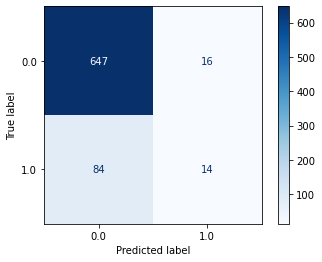

In [261]:
results(log_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [262]:
pipe_knn = Pipeline([
    ('model',KNeighborsClassifier())
])

knn_params = {'model__n_neighbors':[3,4,5,6],
             'model__p':[2,3,4]}

knn_v = GridSearchCV(pipe_knn,
                     knn_params,
                     cv=5,
                     verbose=1)

knn_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 4, 5, 6],
                         'model__p': [2, 3, 4]},
             verbose=1)

Best Score(cross_val_score) is:  0.8667923912626204
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__n_neighbors': 4, 'model__p': 4}
----------------------------------------------------------------------
Train score is:  0.8865030674846626
Test score is:  0.8607095926412615
----------------------------------------------------------------------
Specificity:  0.9803921568627451
Sensitivity:  0.05102040816326531


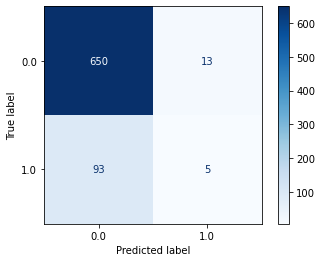

In [263]:
results(knn_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [264]:
pipe_rfc = Pipeline([
    ('model',RandomForestClassifier())
])
rfc_params = {'model__criterion':['gini','entropy'],
              'model__max_features':['auto','sqrt','log2'],
             'model__ccp_alpha':[0.01,0.05,0.07]}
# Support Vector Classifier was modelled in different Notebook due to significant runtimes.
rfc_v = GridSearchCV(pipe_rfc,
                     rfc_params,
                     cv=5,
                     verbose=1)
rfc_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', RandomForestClassifier())]),
             param_grid={'model__ccp_alpha': [0.01, 0.05, 0.07],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_features': ['auto', 'sqrt', 'log2']},
             verbose=1)

Best Score(cross_val_score) is:  0.872043072670736
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_features': 'auto'}
----------------------------------------------------------------------
Train score is:  0.8720420683610868
Test score is:  0.871222076215506
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


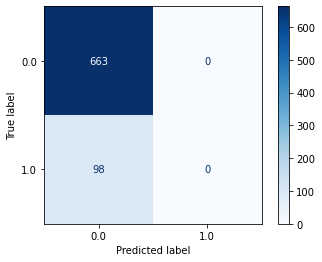

In [265]:
results(rfc_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [266]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada_v = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'model__learning_rate': [0.5, 1, 1.5],
                         'model__n_estimators': [40, 50, 60]},
             verbose=1)

Best Score(cross_val_score) is:  0.8667875926139199
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__learning_rate': 0.5, 'model__n_estimators': 40}
----------------------------------------------------------------------
Train score is:  0.8781770376862401
Test score is:  0.8699080157687253
----------------------------------------------------------------------
Specificity:  0.9894419306184012
Sensitivity:  0.061224489795918366


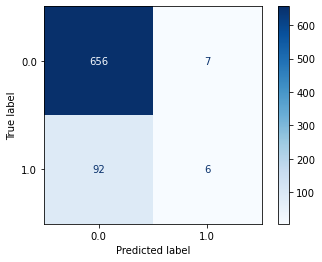

In [267]:
results(ada_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [268]:
pipe_bag = Pipeline([
    ('model',BaggingClassifier())
])
bag_params = {'model__n_estimators':[10,20,30],
              'model__max_samples':[1,2,3]
             }
bag_v = GridSearchCV(pipe_bag,
                     bag_params,
                     cv=5,
                     verbose=1)
bag_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   11.9s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', BaggingClassifier())]),
             param_grid={'model__max_samples': [1, 2, 3],
                         'model__n_estimators': [10, 20, 30]},
             verbose=1)

Best Score(cross_val_score) is:  0.872043072670736
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__max_samples': 1, 'model__n_estimators': 10}
----------------------------------------------------------------------
Train score is:  0.8720420683610868
Test score is:  0.871222076215506
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


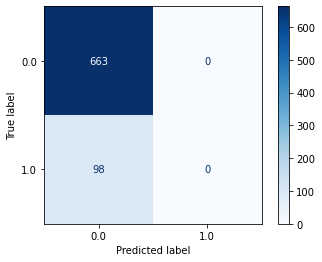

In [269]:
results(bag_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [270]:
pipe_bag = Pipeline([
    ('model',SVC())
])
svc_params = {'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc_v = GridSearchCV(pipe_bag,
                     svc_params,
                     cv=5,
                     verbose=1)
svc_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   35.9s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', SVC())]),
             param_grid={'model__C': [0.01, 0.05], 'model__degree': [3, 4, 5]},
             verbose=1)

Best Score(cross_val_score) is:  0.872043072670736
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.01, 'model__degree': 3}
----------------------------------------------------------------------
Train score is:  0.8720420683610868
Test score is:  0.871222076215506
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


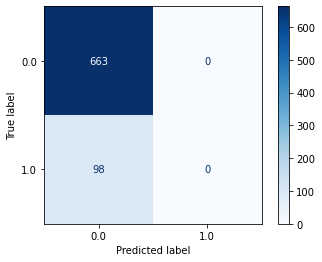

In [271]:
results(svc_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

## Try pipelines with PCA and grid search (note scaling was done above)

In [272]:
pipe_log = Pipeline([
    ('pc',PCA()),
    ('model',LogisticRegression())
])

log_params = {'pc__n_components':[10,15,20],
              'model__max_iter': [500, 1000],
              'model__C': [.1, 1, 10, 100],
              'model__solver': ['liblinear', 'lbfgs', 'sag'],
              'model__penalty': ['l2']}

log_v2 = GridSearchCV(pipe_log,
                     log_params,
                     cv=5,
                     verbose=1)

log_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   28.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'sag'],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8729221851126724
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 100, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'sag', 'pc__n_components': 20}
----------------------------------------------------------------------
Train score is:  0.8720420683610868
Test score is:  0.8659658344283837
----------------------------------------------------------------------
Specificity:  0.9924585218702866
Sensitivity:  0.01020408163265306


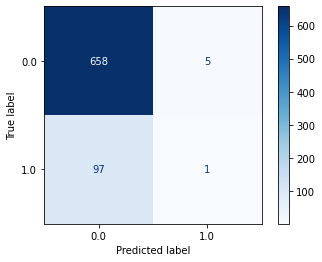

In [273]:
results(log_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [274]:
pipe_knn = Pipeline([
    ('pc',PCA()),
    ('model',KNeighborsClassifier())
])

knn_params = {'pc__n_components':[10,15,20],
              'model__n_neighbors':[3,4,5,6],
             'model__p':[2,3,4]}

knn_v2 = GridSearchCV(pipe_knn,
                     knn_params,
                     cv=5,
                     verbose=1)

knn_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  2.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 4, 5, 6],
                         'model__p': [2, 3, 4],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8711697186072402
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__n_neighbors': 6, 'model__p': 4, 'pc__n_components': 15}
----------------------------------------------------------------------
Train score is:  0.8759859772129711
Test score is:  0.8659658344283837
----------------------------------------------------------------------
Specificity:  0.9924585218702866
Sensitivity:  0.01020408163265306


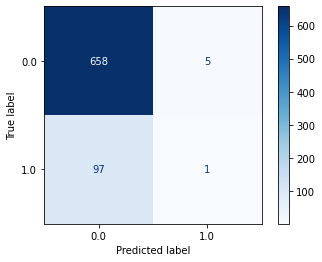

In [275]:
results(knn_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [276]:
pipe_rfc = Pipeline([
    ('pc',PCA()),
    ('model',RandomForestClassifier())
])
rfc_params = {'pc__n_components':[10,15,20],
              'model__criterion':['gini','entropy'],
              'model__max_features':['auto','sqrt','log2'],
             'model__ccp_alpha':[0.01,0.05,0.07]}
# Support Vector Classifier was modelled in different Notebook due to significant runtimes.
rfc_v2 = GridSearchCV(pipe_rfc,
                     rfc_params,
                     cv=5,
                     verbose=1)
rfc_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 11.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__ccp_alpha': [0.01, 0.05, 0.07],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.872043072670736
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_features': 'auto', 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8720420683610868
Test score is:  0.871222076215506
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


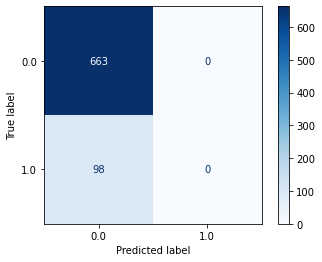

In [277]:
results(rfc_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [278]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada_v2 = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'model__learning_rate': [0.5, 1, 1.5],
                         'model__n_estimators': [40, 50, 60],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8873325271603516
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__learning_rate': 0.5, 'model__n_estimators': 40, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.889083735203858
Test score is:  0.8883048620236531
----------------------------------------------------------------------
Specificity:  0.9970014992503748
Sensitivity:  0.11702127659574468


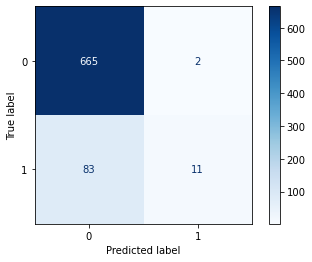

In [174]:
results(ada_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

### The AdaBoost model performed the best here for state violence, but only barely above the baseline.

In [175]:
pipe_bag = Pipeline([
    ('pc',PCA()),
    ('model',BaggingClassifier())
])
bag_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[10,20,30],
              'model__max_samples':[1,2,3]
             }
bag_v2 = GridSearchCV(pipe_bag,
                     bag_params,
                     cv=5,
                     verbose=1)
bag_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   26.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', BaggingClassifier())]),
             param_grid={'model__max_samples': [1, 2, 3],
                         'model__n_estimators': [10, 20, 30],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8772476870513263
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__max_samples': 3, 'model__n_estimators': 10, 'pc__n_components': 15}
----------------------------------------------------------------------
Train score is:  0.8768084173608066
Test score is:  0.8764783180026281
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


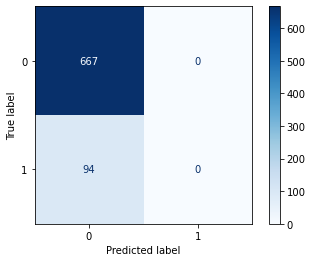

In [176]:
results(bag_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [199]:
pipe_svc = Pipeline([
    ('pc',PCA()),
    ('model',SVC())
])
svc_params = {'pc__n_components':[10,15,20],
              'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc_v2 = GridSearchCV(pipe_svc,
                     svc_params,
                     cv=5,
                     verbose=1)
svc_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.7s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('pc', PCA()), ('model', SVC())]),
             param_grid={'model__C': [0.01, 0.05], 'model__degree': [3, 4, 5],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8768090905600981
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.01, 'model__degree': 3, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8768084173608066
Test score is:  0.8764783180026281
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


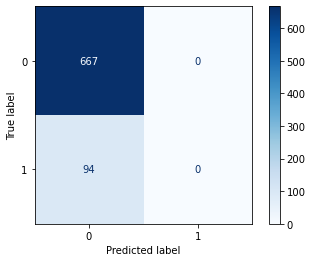

In [200]:
results(svc_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)